# ДЗ №6 - автокодировщики для идентификации аномалий

В этом ДЗ вам предстоит применить модель сврточного автокодировщика для идентификации аномалий в данных.

Для этого вам потребуется создать сверточный автокодировщик, обучить его и применить к тестовым данным.

Основная идея фильтрации аномалий состоит в том, что экземпляры выборки, являющиеся аномалиями, сильно отличаются от всех остальных объектов. Кроме того, их мало по сранению с размером всей выборки.
Этот набор факторов приводит к тому, что автокодировщик, обученный на данных тренировочной выборки, будет довольно плохо восстанавливать примеры-аномалии. То есть, значения функции потерь на таких примерах ожидается нетипично высоким.

In [1]:
# Эту ячейку следует выоплнять в окружении, в котором еще не установлены необходимые библиотеки. В подготовленном окружении эту ячейку можно пропустить.
!pip3 install torch torchvision numpy matplotlib

In [2]:
!pip3 install -U albumentations

     |████████████████████████████████| 81kB 4.3MB/s 
     |████████████████████████████████| 952kB 7.5MB/s 
     |████████████████████████████████| 38.2MB 79kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
from skimage.io import imshow
from sklearn.model_selection import train_test_split

# trying new augmentation library
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from typing import Tuple, List, Type, Dict, Any

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cuda device


# Константы

In [5]:
RESIZE_SHAPE = (28, 28)
BATCH_SIZE = 256

# Свёрточный автокодировщик (convolutional autoencoder, CAE)

Данными в этой задаче будут все так же набор рукописных цифр MNIST. Однако некоторые экземпляры тестовой выборки оказываются испорченными. Ваша цель - найти эти экземпляры в предположении, что они представляют собой аномалии.

Данные MNIST с дефектами нужно скачать в виде файла по <a href="https://www.dropbox.com/s/r7mgjn83y9ygpzq/mnist_corrupted.npz">ссылке</a>

Прежде всего следует построить и обучить свёрточный автокодировщик.

>Кодирующая часть автокодировщика (encoder, кодировщик) может состоять из сверточных слоев (convolutional layers) и слоев субдискретизации (pooling layers), но может быть и сложнее. Здесь предлагается применить ваши знания относительно возможной структуры сверточных сетей. Кодировщик, будучи обученным, позволяет извлечь скрытое представление (hidden representation, embeddings) входных примеров, содержащее достаточно информации для восстановления этих примеров декодером.

> Декодер (decoder) может состоять из слоев типа **transpose convolution** и операций масштабирования (upsampling), но также, как и кодировщик, может быть сложнее. Декодер должен восстанавливать примеры, руководствуюясь их векторами скрытого представления.

<img src='imgs/autoencoder_1.png' />

### Скрытое представление (hidden representation, compressed representation)

Скрытое представление может содержать семантически насыщенную информацию о входных примерах. С использованием этих данных можно проводить фильтрацию шума в примерах, восстанавливать сами примеры, и иногда даже проводить некоторые операции в семантическом пространстве.

In [6]:
!wget https://www.dropbox.com/s/r7mgjn83y9ygpzq/mnist_corrupted.npz

--2021-05-08 14:10:33--  https://www.dropbox.com/s/r7mgjn83y9ygpzq/mnist_corrupted.npz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r7mgjn83y9ygpzq/mnist_corrupted.npz [following]
--2021-05-08 14:10:33--  https://www.dropbox.com/s/raw/r7mgjn83y9ygpzq/mnist_corrupted.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc715f48f47c6ce906f40a5b2b82.dl.dropboxusercontent.com/cd/0/inline/BOEhW2vb4yQEX5LghYRUaeT8l21kBoQ6qxtRc2XZRxNRBsKhA0u-rLhkkXw8bz2ixBypKexWRvgvx_Atyif0bMi8uT8FOX2J9LXBHU344SgSYEEZpsqJobdRZAYFjSb55r6-n3pma-WQWj-Cf2mcA9O3/file# [following]
--2021-05-08 14:10:33--  https://uc715f48f47c6ce906f40a5b2b82.dl.dropboxusercontent.com/cd/0/inline/BOEhW2vb4yQEX5LghYRUaeT8l21kBoQ6qxtRc2XZRxNRBsKhA0u-rLhkkXw8bz2ixBypK

В предположении, что файл данных `mnist_corrupted.npz` загружен и находится в той же директории, что и этот нотбук, генераторы данных можно описать следующим образом:

In [7]:
class DS(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]

        if self.transform:
            x = self.transform(image=x)['image']

        return x

    def __len__(self):
        return len(self.data)

In [8]:
train_val_transforms = A.Compose(
    [
     A.ToFloat(max_value=255),
     A.Resize(height=RESIZE_SHAPE[0], width=RESIZE_SHAPE[1]),
     A.Rotate(limit=20),
     A.RandomBrightness(limit=0.1),
     ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
     A.ToFloat(max_value=255),
     A.Resize(height=RESIZE_SHAPE[0], width=RESIZE_SHAPE[1]),
     ToTensorV2(),
    ]
)

In [9]:
mnist = np.load('./mnist_corrupted.npz')
train_val_samples = mnist['x_train']
test_samples = mnist['x_test']
train_val_dataset = DS(train_val_samples, train_val_transforms)
test_dataset = DS(test_samples, test_transforms)

In [10]:
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.10)

print(f'size of data for training: {len(train_dataset)}, size of data for validation: {len(val_dataset)}')

size of data for training: 54000, size of data for validation: 6000


## Инициализация Dataloader'ов

In [11]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
}

### Визуализация исходных данных

Как и в любой задаче, имеет смысл визуализировать исходные данные, чтобы понимать, с чем мы имеем дело

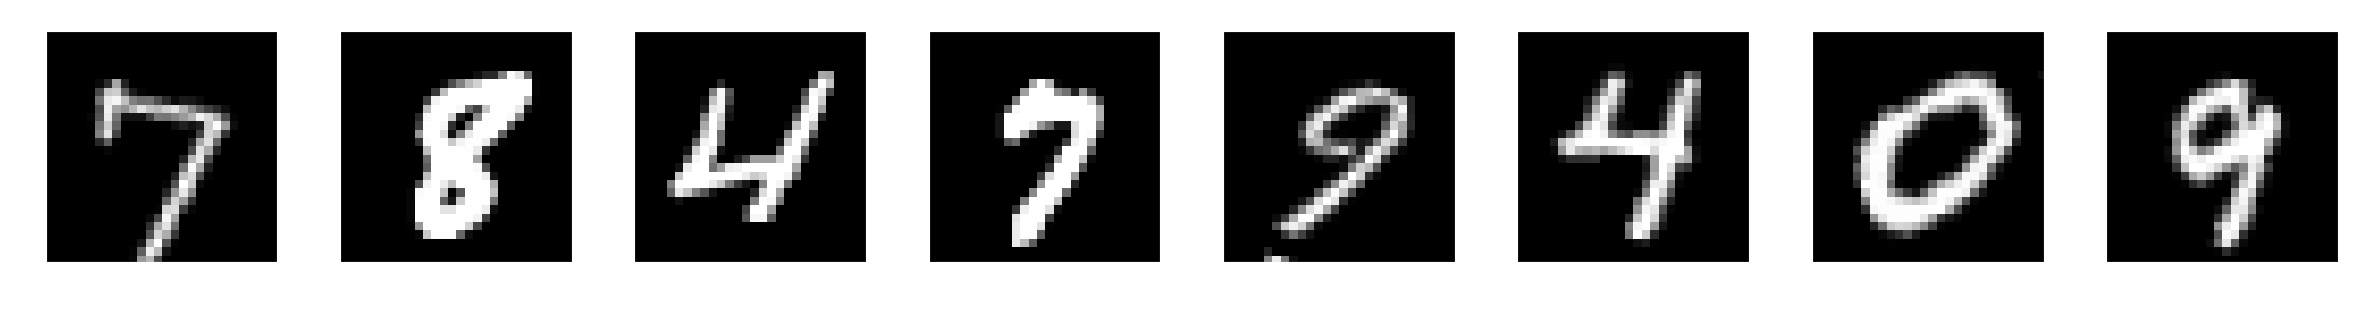

In [12]:
indices = np.random.randint(0, len(train_val_dataset), size=8)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(8, 2), dpi=300)
for i, ax in enumerate(axes):
    sample_index = indices[i]
    sample = train_val_dataset[sample_index]
    ax.imshow(np.squeeze(sample.cpu().numpy()), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.patch.set_facecolor('white')

---
## Свёрточный автокодировщик

#### Кодировщик (Encoder)
Кодировщик можно реализовать в подходе AlexNet или VGG: сверточные (convolutional) слои чередуются со слоями субдискретизации (pooling). Последние применяются для снижения пространственных размерностей промежуточных представлений входных примеров. Нередко после сверточной части добавляют дополнительные полносвязные слои, позволяющие еще сильнее снизить размерность скрытого представления, извлекаемого кодировщиком.

Предлагаемая структура кодировщика не единственно верная. Можно реализовывать и другие.

#### Декодер

Декодер должен преобразовать вектор скрытого представления (тензор ранга 1) в изображение, реконструкцию входного примера. Для этого следует вектор скрытого представления перевести в ранг 2 (например, операцией `.view()`). После этого следует последовательно применять операции Transpose Convolution (`torch.nn.ConvTranspose2d`) и масштабирования (upsampling, а именно `torch.nn.functional.interpolate`). В некоторых случаях применяют `torch.nn.ConvTranspose2d` с аргументом `stride=2` или больше. Однако такое использование может привести в т.н. ["эффекту шахматной доски"](https://distill.pub/2016/deconv-checkerboard/). Рекомендуемым вариантом сейчас считается применение масштабирования типа билинейного или бикубического.

Результатом работы декодера должно получиться изображение, по размеру совпадающее с входным примером, то есть, 28x28.

Не следует забывать, что одной из целей применения автокодировщиков является снижение размерности примеров с сохранением ключевой информации. Экспериментируйте с количеством слоев и размерностью скрытого представления! Попробуйте снизить его до 2 или вообще до 1. Хорошо ли будут воспроизводиться примеры выборки?

### Transpose Convolutions

В этом ДЗ в декодере предлагается использовать слои типа **transposed convolutional**. Они работают практически так же, как свёрточные слои, но "задом наперед". Например, ядро размером 3x3 в случае свёрточной операции дает в результате одно значение. Операция **transposed convolutional**, наоборот, одно значение входного представления трансформирует в патч размером с его ядро (3x3). В PyTorch есть уже готовая реализация слоев [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d).

Повторимся, альтернативой использованию **transposed convolutional layer** с аргументом `stride=2` или больше может быть применение операций изменения размера (resizing) с интерполяцией типа "nearest neighbor", "bilinear" или "bicubic" и применением свёрточной операции к результату.

### Задание 1:  Описать класс нейросети-автокодировщика, описываемой в этом задании.

In [13]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self, hidden_dim=32):
        super(ConvAutoencoder, self).__init__()
        self.embedding = None

        ## слои кодировщика ##
        self.enc_conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)  # 4 x 28 x 28
        self.enc_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 4 x 14 x 14
        self.enc_batch_norm_1 = nn.BatchNorm2d(num_features=4)

        self.enc_conv_2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)  # 8 x 14 x 14
        self.enc_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 8 x 7 x 7
        self.enc_batch_norm_2 = nn.BatchNorm2d(num_features=8)

        self.flatten = nn.Flatten()  # 1 x 392
        self.enc_linear_1 = nn.Linear(in_features=392, out_features=hidden_dim)
        
        ## слои декодера ##
        self.de_linear_1 = nn.Linear(in_features=hidden_dim, out_features=392)

        self.de_conv_1 = nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.de_pool_1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.de_batch_norm_1 = nn.BatchNorm2d(num_features=4)

        self.de_conv_2 = nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.de_pool_2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.de_batch_norm_2 = nn.BatchNorm2d(num_features=1)

    def forward(self, x):
        ## операции кодировщика ##
        original_shape = x.shape

        x = F.relu(self.enc_conv_1(x))  # 4 x 28 x 28
        x = self.enc_pool_1(x)  # 4 x 14 x 14
        x = self.enc_batch_norm_1(x)  # 4 x 14 x 14

        x = F.relu(self.enc_conv_2(x))  # 8 x 14 x 14
        x = self.enc_pool_2(x)  # 8 x 7 x 7
        x = self.enc_batch_norm_2(x) # 8 x 7 x 7

        x_shape = x.shape
        x = self.flatten(x)  # 1 x 392
        self.embedding = F.relu(self.enc_linear_1(x))  # 1 x hidden_dim

        ## операции декодера ##
        x = self.de_linear_1(self.embedding)  # 1 x 392
        x = x.view(*x_shape)  # 8 x 7 x 7

        x = F.relu(self.de_conv_1(x))  # 4 x 7 x 7
        x = self.de_pool_1(x)  # 4 x 14 x 14
        x = self.de_batch_norm_1(x)  # 4 x 14 x 14        

        x = F.relu(self.de_conv_2(x))  # 1 x 14 x 14
        x = self.de_pool_2(x)  # 1 x 28 x 28
        x = torch.sigmoid(x)  # 1 x 28 x 28

        assert original_shape == x.shape, f'{original_shape} != {x.shape}'                        
        return x

In [14]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (enc_conv_1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_batch_norm_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv_2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_batch_norm_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (enc_linear_1): Linear(in_features=392, out_features=32, bias=True)
  (de_linear_1): Linear(in_features=32, out_features=392, bias=True)
  (de_conv_1): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (de_pool_1): Upsample(scale_factor=2.0, mode=bilinear)
  (de_batch_norm_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (de_con

In [15]:
model = model.to(device)

### Задание 2: Напишите пайплайн для предобработки и аугументации данных.

В `torchvision.transforms` есть готовые реализации большинства распространённых техник, если вы хотите добавить что-то своё, вы можете воспользоваться `torchvision.transforms.Lambda` или встроить аугментации на этапе подготовки данных в классе `DS`.

### Написан выше при помощи `Albumentations`

Всегда имеет смысл посмотреть, как происходит предобработка данных, и как происходит обработка данных нейросетью (если это возможно). В этом ДЗ предлагается визуализировать произвольные примеры из обучающей выборки, а также один из произвольных примеров, обработанных только что созданной (но не обученной) моделью.

### Задание 3: отобразите несколько произвольных примеров обучающей выборки.

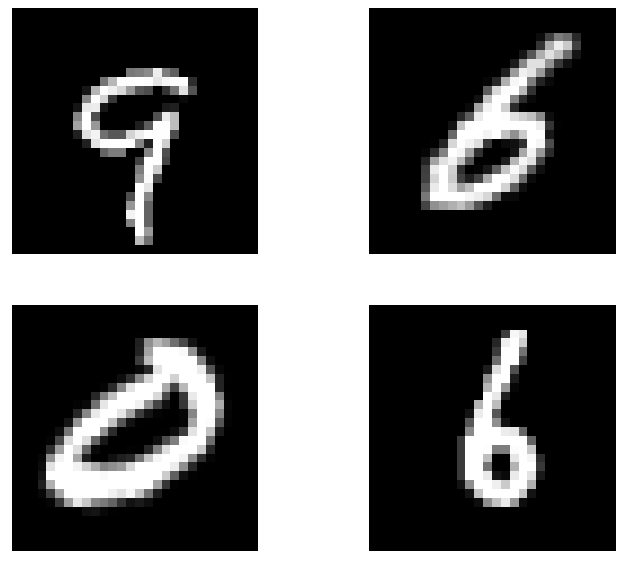

In [16]:
NUM = 2
fig, ax = plt.subplots(NUM, NUM, figsize=(7, 7))
plt.subplots_adjust(left=NUM*(-0.2), bottom=NUM*(-0.1))

for i in range(NUM**2):
    idx = np.random.randint(low=0, high=len(val_dataset))
    image = val_dataset[idx]
    
    ax[i // NUM, i % NUM].imshow(image.squeeze(), cmap='gray')
    ax[i // NUM, i % NUM].set_xticks([])
    ax[i // NUM, i % NUM].set_yticks([])
    ax[i // NUM, i % NUM].grid(False);

### Задание 4: отобразите один произвольный пример обучающей выборки и результат вычисления нейросети на этом примере.

In [17]:
example_index = int(np.random.randint(0, len(train_dataset), size=1))
example = train_dataset[example_index]

## compute model output for this example;
## Transfer the result to CPU and convrt it from tensor to numpy array
example_transformed = model(example.unsqueeze(0).to(device))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


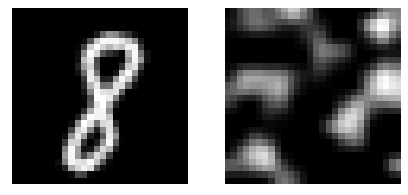

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(7, 6))

for i, img in enumerate((example, example_transformed)):
  img = img.cpu().detach().numpy().squeeze()
  ax[i].imshow(img, cmap='gray')
  ax[i].grid(False)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

### Обучение модели

Теперь, когда вы реализовали модель и подготовили данные, можно приступить к непосредственному обучению модели.

Костяк функции обучения написан ниже, далее вы должны будете реализовать ключевые части этого алгоритма

In [19]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = nn.MSELoss(reduction='mean'),
                metrics_function: torch.nn.Module=nn.L1Loss(reduction='mean'),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim.Adam,
                optimizer_params: Dict = {},
                lr_scheduler_class: Any = torch.optim.lr_scheduler.StepLR,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 100,
                early_stopping_patience = 10
):

    metrics = {'loss': [], 'metrics': []}

    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    
    for epoch in range(max_epochs):
        print(f'Epoch {epoch+1} of {max_epochs}')
        train_single_epoch(model, optimizer, loss_function, train_loader)

        val_metrics = validate_single_epoch(model, loss_function, metrics_function, val_loader)
        metrics['loss'].append(val_metrics['loss'])
        metrics['metrics'].append(val_metrics['metrics'])
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step()
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            # torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            break

    return metrics

### Задание 5:  Реализуйте функцию, производящую обучение сети на протяжении одной эпохи ( полного прохода по всей обучающей выборке ). На вход будет приходить модель, оптимизатор, функция потерь и объект типа `DataLoader`.
> ВНИМАНИЕ!!! В задаче обучения автокодировщика нет меток-цифр. Есть только входные примеры. При итерировании по `data_loader` вы будете получать только сами примеры! Подумайте, что должно выступать в качестве целевой переменной, когда вы вычисляете функцию потерь.

In [20]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    model.train()
    for X in data_loader: 
        # send data on correct device type
        X = X.to(device)

        # vanish gradient
        optimizer.zero_grad()

        # forward-pass
        X_pred = model(X)  

        # calculating loss value
        loss = loss_function(X_pred, X)
        
        # backward-pass
        loss.backward()

        # optimization step
        optimizer.step() 

### Задание 6:  Реализуйте функцию производящую расчёт функции потерь на тестовой выборке.  На вход будет приходить модель, функция потерь и DataLoader. На выходе ожидается словарь с вида:
```
{
    'loss': <среднее значение функции потерь>,
    'accuracy': <среднее значение точности модели>
}
```

In [21]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module,
                          metric_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    test_loss = 0.0
    running_loss = 0.0
    running_metrics = 0.0

    with torch.no_grad():
        for X in data_loader:
            # send data on correct device type
            X = X.to(device)

            # forward-pass
            X_pred = model(X)

            # accumulating statistics
            running_loss += loss_function(X_pred, X).item()
            running_metrics += metric_function(X_pred, X).item()
    
    return {
        'loss': running_loss / (RESIZE_SHAPE[0]*RESIZE_SHAPE[1]),
        'metrics': running_metrics / (RESIZE_SHAPE[0]*RESIZE_SHAPE[1]),
    }

Если вы корректно реализовали все предыдущие шаги и ваша модель имеет достаточное количество обучаемых параметров, то в следующей ячейке должен пойти процесс обучения.

### Задание 7: придумайте функцию потерь.

Обратите внимание, что в предложенном скелетном коде функция потерь по умолчанию прописана неверно. Вы, скорее всего, не сможете обучить автокодировщик с этой функцией потерь. Подумайте, какая должна быть функция потерь при условии, что она должна оценивать качество воспроизведения значений в каждом отдельном пикселе изображения. Впишите в ячейке ниже правильную функцию потерь. Подумайте, можно ли использовать уже предложенную функцию потерь, и что нужно сделать с данными, чтобы с ней можно было обучить вашу модель.

## **Ответ**:

Да, на мой взгляд тоже, кросс-энтропия не подходит для решения задачи, так как по своей задумке, кросс-энтропия используется в том случае, когда ответ алгоритма - вероятность принадлежности классу `y`.

Но ведь у нас же, хотя значение пикселя и лежит от нуля до единицы, но не является вероятностью, так как при такой интерпретации, единица отвечала бы тому, что пиксель белый, а ноль - черный. Но на изначальном изображении, яркости пискелей принимают не бинарное значение, а непрерывное в отрезке [0, 1]. Поэтому по своей сути мы решаем задачу *регрессии*, а не классификации.


В таком случае, я предлагаю использовать `pixel-wise MSE`.


Впрочем, кросс-энтропию тоже можно было бы использовать, если, например, преобразовать исходные данные таким образом, что они принимали бы лишь значения вида 0.0, 0.1, 0.2,... 1.0. Тогда бы это уже была классификация.

In [22]:
metrics = train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset,
            optimizer_params={'lr': 1e-2},
            lr_scheduler_params={'step_size': 60}, 
            batch_size=BATCH_SIZE,
            max_epochs=200)

Epoch 1 of 200


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Validation metrics: 
{'loss': 0.006420072073078886, 'metrics': 0.013567481075926703}
Best model yet, saving
Epoch 2 of 200
Validation metrics: 
{'loss': 0.006366890703080868, 'metrics': 0.013481628263787347}
Best model yet, saving
Epoch 3 of 200
Validation metrics: 
{'loss': 0.006346111299888212, 'metrics': 0.013428432220707134}
Best model yet, saving
Epoch 4 of 200
Validation metrics: 
{'loss': 0.00633398819790811, 'metrics': 0.013415896428786978}
Best model yet, saving
Epoch 5 of 200
Validation metrics: 
{'loss': 0.006335926489258299, 'metrics': 0.013359422966533778}
Epoch 6 of 200
Validation metrics: 
{'loss': 0.0063232653679288165, 'metrics': 0.013378818120275224}
Best model yet, saving
Epoch 7 of 200
Validation metrics: 
{'loss': 0.006316711460905415, 'metrics': 0.013351644294298425}
Best model yet, saving
Epoch 8 of 200
Validation metrics: 
{'loss': 0.006323257651256055, 'metrics': 0.013403266212161707}
Epoch 9 of 200
Validation metrics: 
{'loss': 0.006312744235809968, 'metrics':

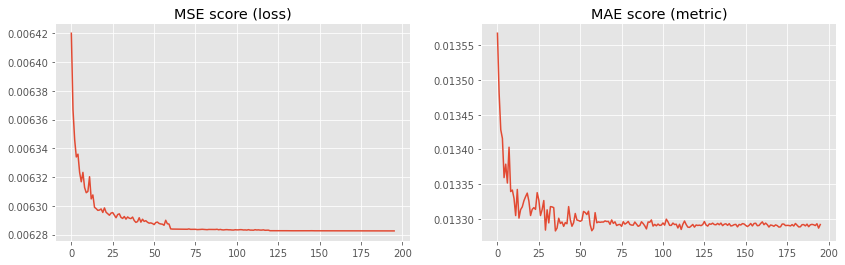

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))


ax[0].plot(metrics['loss'])
ax[0].set_title('MSE score (loss)')

ax[1].plot(metrics['metrics'])
ax[1].set_title('MAE score (metric)');

## Проверка результатов

Посмотрите, как ваш обученный автокодировщик преобразует входные примеры. В ячейке ниже приведен код для отображения произвольной пары пример-реконструкция.

In [28]:
index = int(np.random.randint(0, len(train_dataset), size=1))
sample = train_dataset[index][0]
sample_np = np.squeeze(sample.detach().cpu().numpy())
sample_ae = model(sample.view(1,1,28,28).to(device))
sample_ae_np = np.squeeze(sample_ae.detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


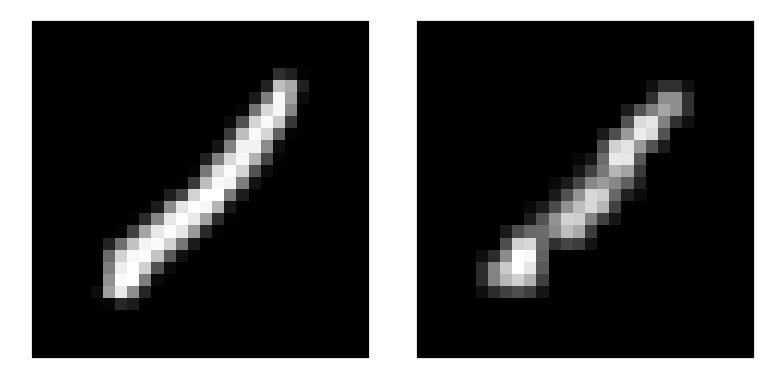

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), dpi=200)

for i, ax in enumerate(axes):
    img = sample_np if i==0 else sample_ae_np
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.imshow(img, cmap='gray')

## Идентификация аномалий.

Идея идентификации аномалий состоит в том, чтобы разделить "обычные" экземпляры и "необычные" по значению функции потерь автокодировщика на этих примерах. Предполагается, что автокодировщик, обученный на обычных примерах не будет способен достаточно точно воспроизвести необычные примеры. То есть, значение функции потерь на необычных экземплярах будет большим. В этом ДЗ предлагается найти все экземпляры-выбросы, встречающиеся в тестовой выборке, руководствуюясь только значениями функции потерь автокодировщика. Для этого на всех объектах тестовой выборки следует вычислить функцию потерь обученного автокодировщика, и определить, какие экземпляры являются аномальными.

В качестве решения всего задания следует получить список значений 0 или 1, соответствующих объектам тестовой выборки. Признак `1` означает, что этот объект является аномалией, `0` - означает, что объект обычный.

Например, следующий список `[1,1,1,0,0,0,0,0,0,0,1,0]` означает, что в выборке из 12 объектов тестовой выборки аномалиями считаются первые три и предпоследний. Остальные считаются обычными.

> ВНИМАНИЕ! Сопоставление при проверке будет производиться только по номерам объектов в тестовой выборке. Поэтому выборку при вычислении функции потерь не следует перемешивать. То есть, при создании загрузчика данных `torch.utils.data.DataLoader` аргумент перемешивания должен быть выключен: `shuffle=False`

### Задание 8: примените обученную модель автокодировщика к данным тестовой выборки. Вычислите функцию потерь на каждом объекте тестовой выборки.

In [30]:
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

losses = []
metric = nn.MSELoss()

with torch.no_grad():
    with tqdm(total=len(test_loader)) as pbar:
        for data in test_loader:
            ## здесь следует вычислить значения функции потерь для всех элементов тестовой выборки.
            data = data.to(device)
            data_pred = model(data)
            curr_loss = metric(data_pred, data).item() / (RESIZE_SHAPE[0] * RESIZE_SHAPE[1])          
            
            losses.append(curr_loss)
            pbar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 10000/10000 [00:12<00:00, 828.74it/s]


## Анализ значений функции потерь
Проанализируйте распределение значений функции потерь и найдите объекты, на которых она слишком большая.

### Задание 9:
- Отобразите гистограмму значений функции потерь. Сделайте выводы (напишите ТЕКСТ) относительно значений для обычных объектов и аномалий.
- Найдите объекты-аномалии, отобразите их.
- Вычислите на них обученный вами автокодировщик. Отобразите рядом объекты-аномалии и их реконструкцию, вычисленную вашим автокодировщиком.

Я предлагаю сделать следующее: давайте посмотрим на примерную плотность, расчитанную по KDE и оценим ее визуально. Видим, что у нас оооооочень длинный хвост в направлении маленького лосса, что довольно странно.

Буквально методом проб и ошибок рассмотрим за границу "доверительного интервала" для лосса квантиль порядка 0.002 и изобразим объекты, лосс на которых меньше этого граничного значения.

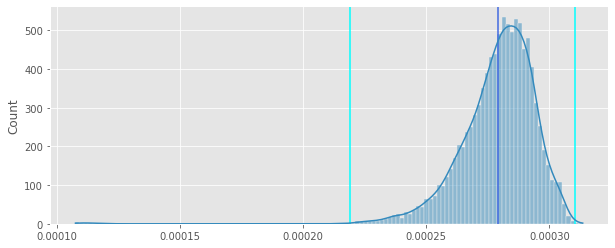

In [52]:
plt.figure(figsize=(10, 4))

mean = np.mean(losses)
left_border = np.quantile(losses, 0.0019)
right_border = mean + 2 * np.std(losses)

plt.axvline(x=mean, ymin=0, ymax=1, color='royalblue')
plt.axvline(x=left_border, ymin=0, ymax=1, color='aqua')
plt.axvline(x=right_border, ymin=0, ymax=1, color='aqua')
sns.histplot(losses, kde=True);

In [53]:
def tensor2numpy(tensor):
    img = tensor.numpy()
    img = np.moveaxis(img, source=(0, 1, 2), destination=(2, 0, 1)).squeeze()

    return img

In [54]:
losses_np = np.array(losses)

outliers = np.where(losses_np < (left_border))
outliers

(array([ 311, 1619, 1774, 2462, 3194, 3474, 3592, 3603, 3768, 4007, 4804,
        5367, 5455, 6573, 8284, 8337, 8659, 9170, 9783]),)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


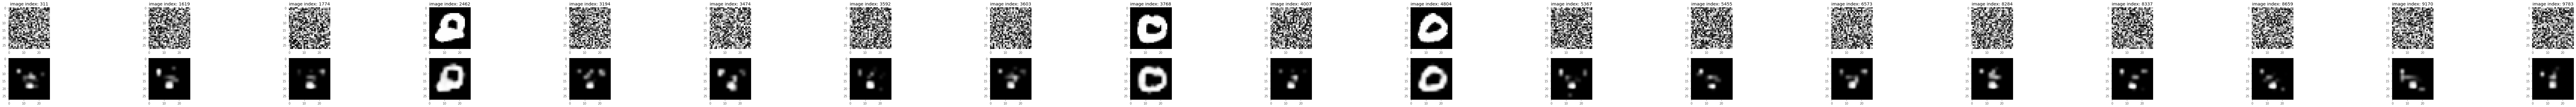

In [55]:
fig, ax = plt.subplots(2, int(len(outliers[0])), figsize=(120, 5))

for idx, outlier_idx in enumerate(outliers[0]):
    data = test_dataset[outlier_idx]
    img = tensor2numpy(data)

    data_pred = model(data.unsqueeze(0).to(device))
    img_pred = tensor2numpy(data_pred.cpu().detach())

    ax[0, idx].imshow(img, cmap='gray')
    ax[1, idx].imshow(img_pred, cmap='gray')
    ax[0, idx].set_title(f'image index: {outlier_idx}')
    ax[0, idx].grid(False)
    ax[1, idx].grid(False)


fig.tight_layout()
fig.subplots_adjust(wspace=0.4)
fig.patch.set_facecolor('white')

Как видим, на аномалиях лосс почему-то сильно МЕНЬШЕ, чем на объектах из генеральной совокупности. Причем, что интересно, глянем на гистограмму изображений аномалий, реконструированных через автокодировщик:

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Text(0.5, 1.0, 'histogram of model(outlier)')

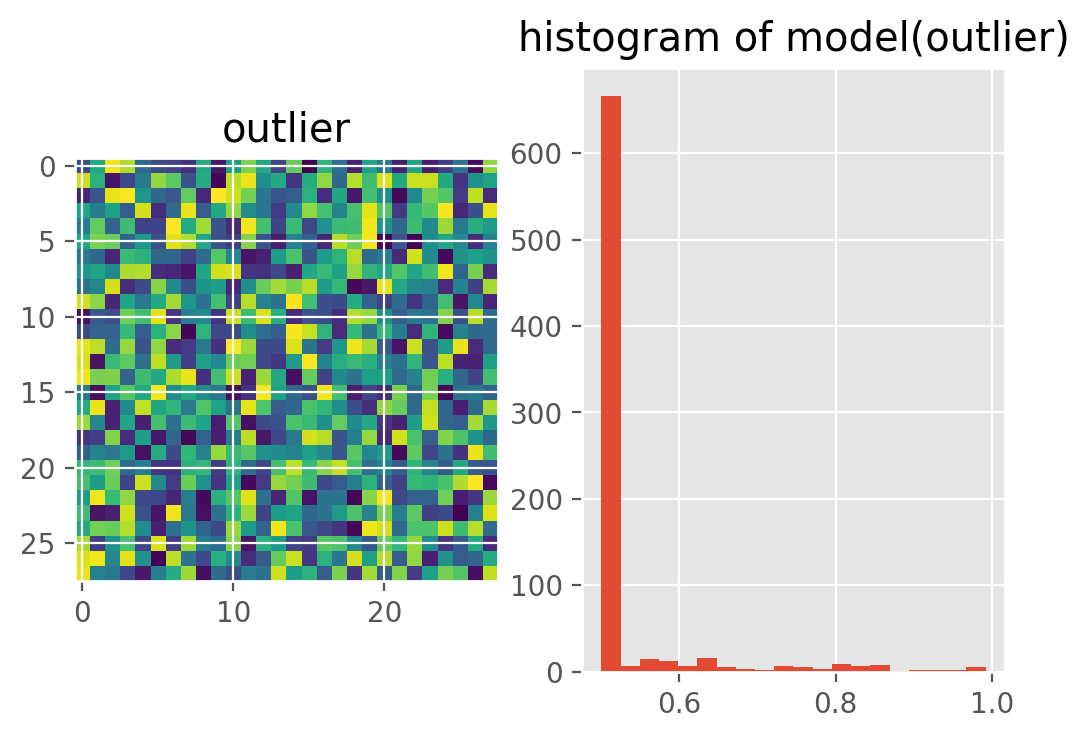

In [73]:
index = int(np.random.randint(0, len(outliers[0]), size=1))
sample = test_dataset[outliers[0][index]]
sample_np = np.squeeze(sample.detach().cpu().numpy())
sample_ae = model(sample.view(1,1,28,28).to(device))
sample_ae_np = np.squeeze(sample_ae.detach().cpu().numpy())


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4), dpi=200)

axes[0].imshow(sample_np)
axes[0].set_title('outlier')
axes[1].hist(np.concatenate(sample_ae_np), bins=20);
axes[1].set_title('histogram of model(outlier)')

Как видим, большинство значений в районе 0.5.

Пока что для меня это больше загадка, почему автокодировщик именно так реагирует на выбросы, так как все-таки ожидались большие значения лосса.

### Задание 10: создайте файл маркировки аномалий

В этом задании требуется записать в файл признаки аномальности для всех объектов тестовой выборки в том порядке, в котором эти объекты идут в выборке. Это должен быть просто текстовый файл. В нем не должно быть никаких заголовков, никаких дополнительных символов. Только `0` или `1`

<br />
пример содержимого файла (для выборки длиной 244 объекта, из которых 6 оказались помечены как аномалии):

`0000000000000010000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000001100000000`

<br /><br />
Финальным решением этого ДЗ является этот файл. Его нужно сдать вместе с ноутбуком с вашим кодом.

In [94]:
final_outliers = np.array([311, 1619, 1774, 3194, 3474, 3592, 3603, 4007, 5367, 5455, 6573, 8284, 8337, 8659, 9170, 9783])
final_outliers.shape

(16,)

In [95]:
answer = np.array([1 if (i in final_outliers) else 0 for i in range(len(test_loader.dataset))])


assert (answer[final_outliers] == np.ones(shape=final_outliers.shape)).all()

In [96]:
answer_str = ''.join([str(i) for i in answer])
answer_str

'000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [97]:
f = open("answer.txt", "w")
f.write(answer_str)
f.close()